In [1]:
import sys
import os
import torch.distributions
import torch
import gym
import random
import numpy as np
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math
from collections import defaultdict
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
# from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame
from gym3 import ToBaselinesVecEnv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# Import custom modules
import heist
import helpers
from helpers import generate_action, load_model

# Reload modules automatically
%load_ext autoreload
%autoreload 2



building procgen...done


In [9]:

def train_and_plot_probes(
    objective_activations_dataset: Dict[str, Dict[str, torch.Tensor]], 
    layers_to_probe: Optional[List[str]] = None,
    plot_confusion_matrices: bool = True,
    plot_auroc_scores: bool = True,
    plot_accuracies: bool = True
):
    '''
    Train probes on each layer to predict current objective from activations.

    Args:
    - objective_vectors: dict of dict of objective vectors, where each key is the name of the objective
    (e.g. gem or red_lock) and each value is a dict whose keys are layer names and values are activations for that layer
    that correspond to input images where the player is trying to get to that objective.
    - layers_to_probe: list of layers to probe. If None, all layers will be probed.
    - plot_confusion_matrices: whether to plot confusion matrices.
    - plot_auroc_scores: whether to plot AUROC scores.
    - plot_accuracies: whether to plot accuracies.

    Returns:
    - Accuracies: dict of dict of accuracies, where each key is the name of the objective, and each value is a dict
    whose keys are layer names and values are the accuracy of the probe on that layer.
    '''
    accuracies = {}
    class_accuracies = {}
    auroc_scores = {}
    class_aurocs = {}

    # Ensure that 'gem' is a key and extract the layers from 'gem'
    assert 'gem' in objective_activations_dataset, "'gem' must be a key in the objective_activations_dataset"
    first_key = next(iter(objective_activations_dataset))
    
    for layer in objective_activations_dataset[first_key].keys():
        # Skip layers not in layers_to_probe
        if layers_to_probe is not None and layer not in layers_to_probe:
            continue
        
        # Get dataset of activation, objective pairs
        activation_data = []
        labels = []
        for objective in objective_activations_dataset.keys():
            activations = torch.stack(objective_activations_dataset[objective][layer])  # Normally tuple
            activations = activations.view(activations.shape[0], -1)
            activation_data.append(activations)
            labels += [objective] * activations.shape[0]
        
        # Combine all activation data and labels into single tensors/lists
        combined_activations = torch.cat(activation_data)
        combined_labels = np.array(labels)

        # Create train and test sets
        train_data, test_data, train_labels, test_labels = train_test_split(combined_activations, combined_labels, test_size=0.3, random_state=42)

        # Train logistic regression model
        probe = LogisticRegression(random_state=42, max_iter=40000)
        probe.fit(train_data, train_labels)

        # Predict on test set
        predictions = probe.predict(test_data)
        accuracy = accuracy_score(test_labels, predictions)
        accuracies[layer] = accuracy

        # Calculate AUROC score for multiclass classification
        label_binarized_test = label_binarize(test_labels, classes=list(objective_activations_dataset.keys()))
        decision_scores = probe.decision_function(test_data)
        auroc = roc_auc_score(label_binarized_test, decision_scores, multi_class='ovr')
        auroc_scores[layer] = auroc

        # Calculate AUROC score for each class
        class_aurocs[layer] = {}
        for i, objective in enumerate(objective_activations_dataset.keys()):
            if np.any(label_binarized_test[:, i]):
                class_aurocs[layer][objective] = roc_auc_score(label_binarized_test[:, i], decision_scores[:, i])
            else:
                class_aurocs[layer][objective] = float('nan')  # Handle missing AUROC entries

        # Calculate accuracy for each class
        report = classification_report(test_labels, predictions, output_dict=True)
        class_accuracies[layer] = {objective: report[objective]['precision'] for objective in objective_activations_dataset.keys() if objective in report}
        
        print(f'Layer: {layer}, Overall Accuracy: {accuracy}, AUROC: {auroc}')
        for objective in class_accuracies[layer]:
            auroc_str = class_aurocs[layer].get(objective, "N/A")  # Handle missing AUROC entries
            print(f'  Objective: {objective}, Accuracy: {class_accuracies[layer][objective]}, AUROC: {auroc_str}')

        # Plot confusion matrix
        if plot_confusion_matrices:
            cm = confusion_matrix(test_labels, predictions, labels=list(objective_activations_dataset.keys()))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(objective_activations_dataset.keys()))
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Confusion Matrix for Layer {layer}')
            plt.xticks(rotation=45)
            plt.show()

        # Plot class accuracies and AUROC for the layer
        if plot_accuracies:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=list(class_accuracies[layer].keys()), y=list(class_accuracies[layer].values()), label='Accuracy')
            plt.title(f'Class Accuracies for Layer {layer}')
            plt.ylabel('Accuracy')
            plt.xlabel('Objective')
            plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
            plt.xticks(rotation=45)
            plt.show()

        if plot_auroc_scores:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=list(class_aurocs[layer].keys()), y=list(class_aurocs[layer].values()), label='AUROC', alpha=0.5)
            plt.title(f'Class AUROCs for Layer {layer}')
            plt.ylabel('AUROC')
            plt.xlabel('Objective')
            plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
            plt.xticks(rotation=45)
            plt.show()

    # Plot overall accuracies and AUROC scores
    if plot_accuracies or plot_auroc_scores:
        plt.figure(figsize=(10, 5))
        x = list(accuracies.keys())
        accuracy_values = list(accuracies.values())
        auroc_values = list(auroc_scores.values())

        bar_width = 0.35
        x_indices = np.arange(len(x))

        if plot_accuracies:
            plt.bar(x_indices, accuracy_values, width=bar_width, label='Accuracy')
        if plot_auroc_scores:
            plt.bar(x_indices + bar_width, auroc_values, width=bar_width, label='AUROC')

        plt.title('Probe Accuracies and AUROC by Layer')
        plt.ylabel('Score')
        plt.xlabel('Layer')
        plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
        plt.xticks(x_indices + bar_width / 2, x, rotation=45)
        plt.legend()
        plt.show()





In [4]:
# Load model and setup environment
difficulty = 'hard'
model = helpers.load_model(model_path=f"../model_{difficulty}.pt")
model_activations = helpers.ModelActivations(model)
layer_paths = helpers.get_model_layer_names(model)

In [28]:
objective_activations_dataset = helpers.get_objective_activations(model_activations, layer_paths, 512)
del objective_activations_dataset['empty_maze'] # Get rid of empty maze dataset

print(list(objective_activations_dataset['gem'].keys()))


['conv_seqs_0_conv', 'conv_seqs_0_max_pool2d', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block0', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_0_res_block1', 'conv_seqs_0', 'conv_seqs_1_conv', 'conv_seqs_1_max_pool2d', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block0', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_1_res_block1', 'conv_seqs_1', 'conv_seqs_2_conv', 'conv_seqs_2_max_pool2d', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block0', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1', 'conv_seqs_2_res_block1', 'conv_seqs_2', 'hidden_fc', 'logits_fc', 'value_fc']


Layer: conv_seqs_1, Overall Accuracy: 0.7723048327137546, AUROC: 0.5740433568427933
  Objective: gem, Accuracy: 0.9456521739130435, AUROC: 0.4274023280581454
  Objective: blue_key, Accuracy: 0.7770700636942676, AUROC: 0.952103253826486
  Objective: green_key, Accuracy: 0.7006369426751592, AUROC: 0.23091820460241513
  Objective: red_key, Accuracy: 0.8231292517006803, AUROC: 0.5543338907469342
  Objective: blue_lock, Accuracy: 0.6875, AUROC: 0.385200806895287
  Objective: green_lock, Accuracy: 0.7445255474452555, AUROC: 0.5068383423805111
  Objective: red_lock, Accuracy: 0.6867469879518072, AUROC: 0.9615066713897744


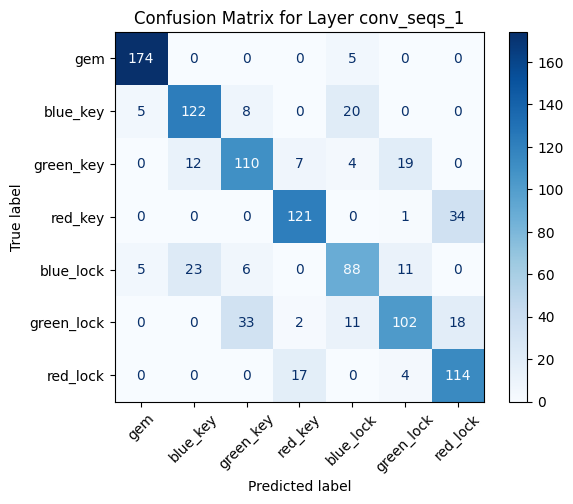

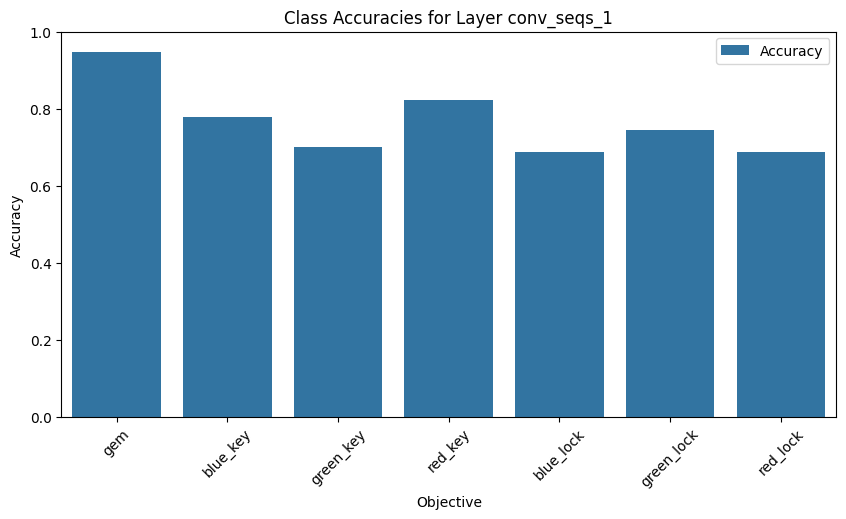

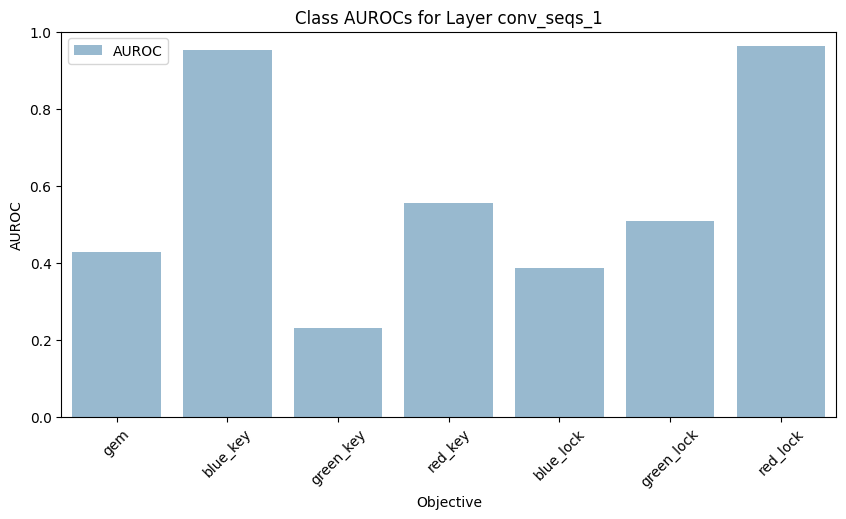

Layer: conv_seqs_2, Overall Accuracy: 0.7695167286245354, AUROC: 0.5882470843764318
  Objective: gem, Accuracy: 0.925531914893617, AUROC: 0.43196751430902514
  Objective: blue_key, Accuracy: 0.8104575163398693, AUROC: 0.9492802353682883
  Objective: green_key, Accuracy: 0.6907894736842105, AUROC: 0.23635082023239912
  Objective: red_key, Accuracy: 0.7463768115942029, AUROC: 0.4698369565217392
  Objective: blue_lock, Accuracy: 0.7196969696969697, AUROC: 0.5121831620408391
  Objective: green_lock, Accuracy: 0.7341772151898734, AUROC: 0.5550377333509864
  Objective: red_lock, Accuracy: 0.7161290322580646, AUROC: 0.9630731688117449


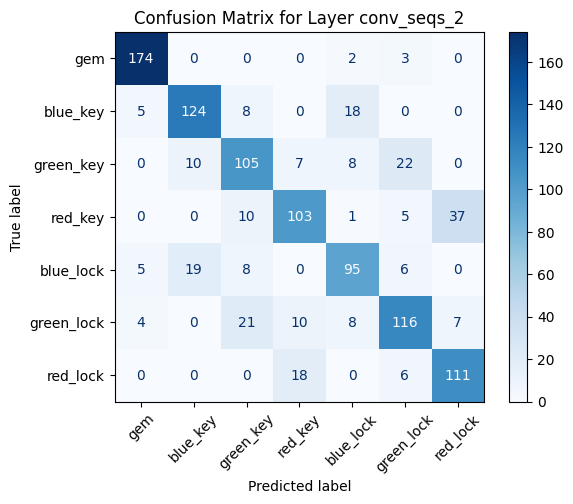

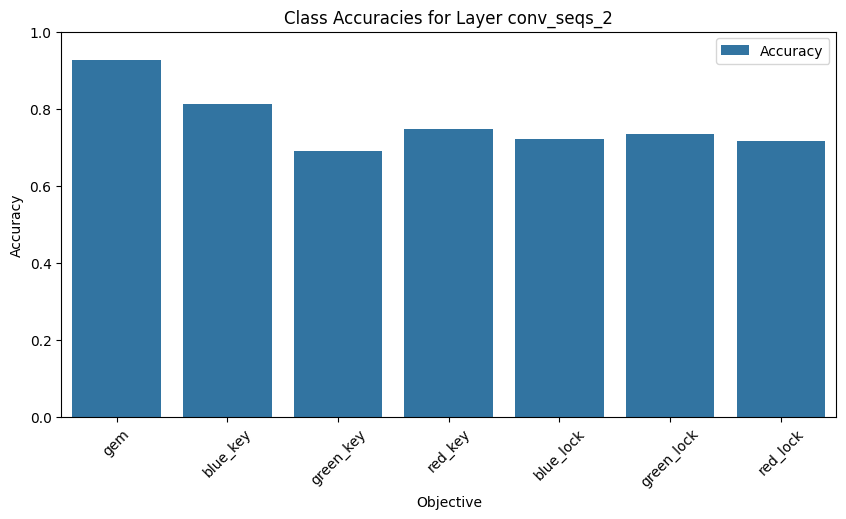

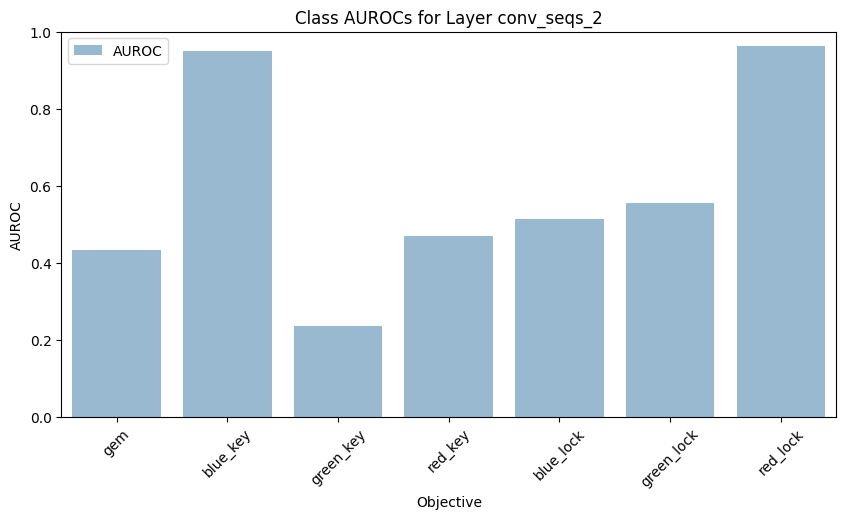

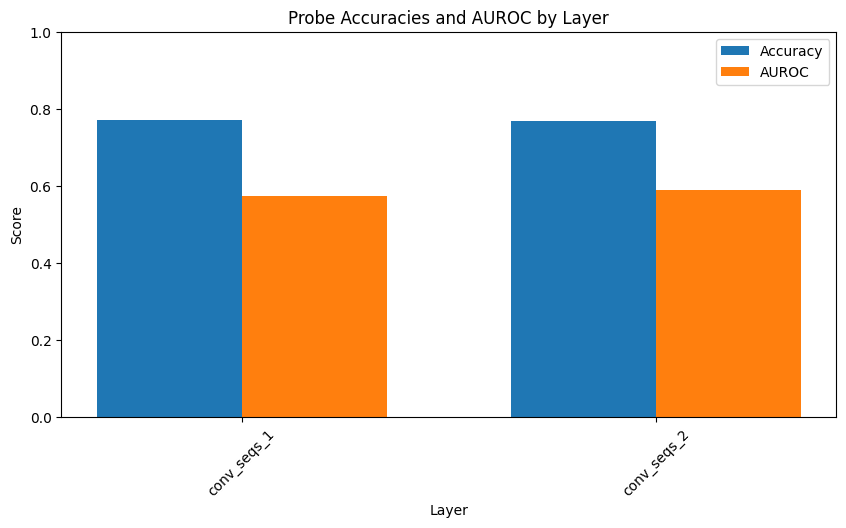

In [30]:
train_and_plot_probes(objective_activations_dataset, ['conv_seqs_1', 'conv_seqs_2'], plot_confusion_matrices=True, plot_auroc_scores=True, plot_accuracies=True)
